<a href="https://www.kaggle.com/code/anshadaziz/tomato-leaves-disease-prediction?scriptVersionId=151631820" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping as ES
from IPython.display import clear_output as cls


import plotly.express as px
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
batchSize = 32
imageShape = (224, 224)
epochs = 10
channels = 3

In [4]:
train_dir = "/kaggle/input/tomatoleaf/tomato/train/"
val_dir = "/kaggle/input/tomatoleaf/tomato/val/"

In [5]:
class_names = sorted(os.listdir(train_dir))
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [6]:
class_dis = [len(os.listdir(train_dir + name)) for name in class_names]
class_dis

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

In [7]:
fig = px.pie(names=class_names, values=class_dis, hole=0.3)
fig.update_layout({"title":{"text":"Distibution of classes", "x":0.50}})
fig.show()

In [8]:
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
val_gen = ImageDataGenerator(rescale=(1./255.))

In [9]:
train_ds = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='training', class_mode='categorical')
val_ds = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='validation', class_mode='categorical')

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [10]:
test_ds = val_gen.flow_from_directory(val_dir,target_size=imageShape,batch_size=batchSize, class_mode='categorical')

Found 1000 images belonging to 10 classes.


In [11]:
def plot_images(data, class_names):
    
    r, c = 3, 4
    imgLen = r*c
    
    plt.figure(figsize=(20, 15))
    i = 1
    
    for images, labels in iter(data):
        
        
        id = np.random.randint(len(images))
#         img = images[id].numpy().astype('uint8')
        img = tf.expand_dims(images[id], axis=0)
        lab = class_names[np.argmax(labels[id])]
        
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        plt.title(lab)
        plt.axis('off')
        cls()
        
        i+=1
        if i > imgLen:
            break
    plt.show()
    

In [ ]:
plot_images(train_ds, class_names)

In [13]:
def get_model():
    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    for layers in base_model.layers:
        layers.trainable = False
        
    base_model_output = base_model.output
    
    x = Flatten()(base_model_output)
    x = Dense(512, activation='relu')(x)
    x = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [14]:
model = get_model()

model.compile(loss="categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [15]:
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=10,
                   steps_per_epoch=len(train_ds),
                   validation_steps=len(val_ds),
                   callbacks=[ES(monitor="val_loss", patience=5)])

Epoch 1/10
250/250 [==============================] - 77s 252ms/step - loss: 1.7562 - accuracy: 0.5254 - val_loss: 0.9435 - val_accuracy: 0.6655
Epoch 2/10
250/250 [==============================] - 27s 107ms/step - loss: 0.6720 - accuracy: 0.7664 - val_loss: 0.7369 - val_accuracy: 0.7510
Epoch 3/10
250/250 [==============================] - 27s 107ms/step - loss: 0.4861 - accuracy: 0.8298 - val_loss: 0.6605 - val_accuracy: 0.7620
Epoch 4/10
250/250 [==============================] - 26s 104ms/step - loss: 0.3294 - accuracy: 0.8879 - val_loss: 0.5030 - val_accuracy: 0.8220
Epoch 5/10
250/250 [==============================] - 27s 108ms/step - loss: 0.2331 - accuracy: 0.9235 - val_loss: 0.4536 - val_accuracy: 0.8470
Epoch 6/10
250/250 [==============================] - 26s 103ms/step - loss: 0.1574 - accuracy: 0.9498 - val_loss: 0.4192 - val_accuracy: 0.8615
Epoch 7/10
250/250 [==============================] - 27s 109ms/step - loss: 0.1041 - accuracy: 0.9701 - val_loss: 0.4554 - val_ac

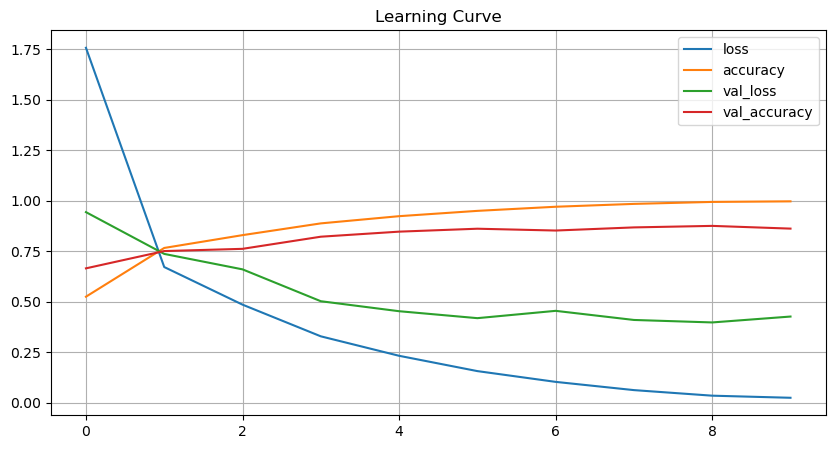

In [16]:
learningcurve = pd.DataFrame(history.history)
learningcurve.plot(figsize=(10, 5))
plt.title("Learning Curve")
plt.grid()

In [17]:
def predictImages(data, class_names, model):
    
    r, c = 3, 4
    imgLen = r*c
    plt.figure(figsize=(20, 15))
    i = 1
    
    for images, labels in iter(data):
        
        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)
        
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        
        predicted = model.predict(img)
        predicted = class_names[np.argmax(predicted)]
        actual = class_names[np.argmax(labels[id])]
        
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")
        plt.axis('off')
        cls()
        
        i+=1
        if i > imgLen:
            break
            
    plt.show()

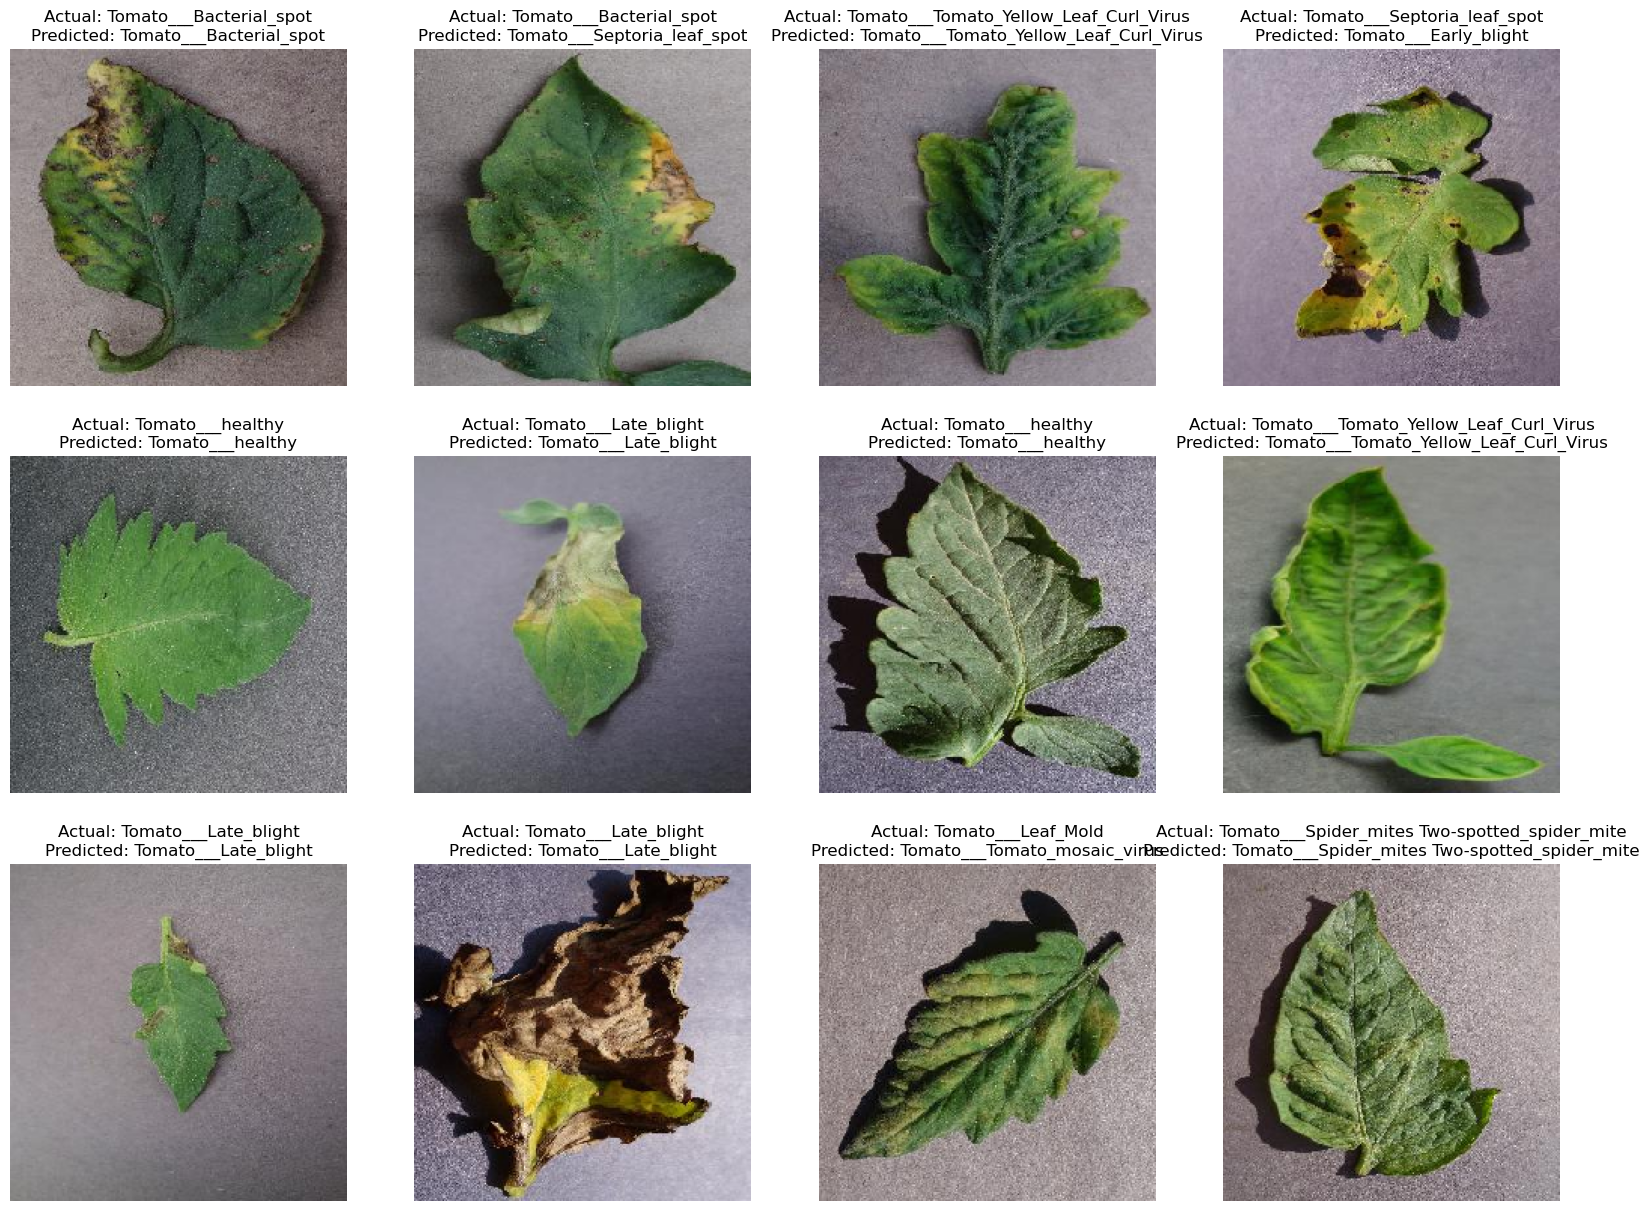

In [18]:
predictImages(test_ds, class_names, model)

In [21]:
import pickle

# Assuming 'model' is your trained machine learning model
with open('tomato_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)